In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
COMMON_NAME = 'Emerald Ash Borer'
SPECIES_NAME = 'Agrilus planipennis'

<ipython-input-3-b87740fca4c9>:53: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(states.geometry.centroid.x, states.geometry.centroid.y, states['name']):


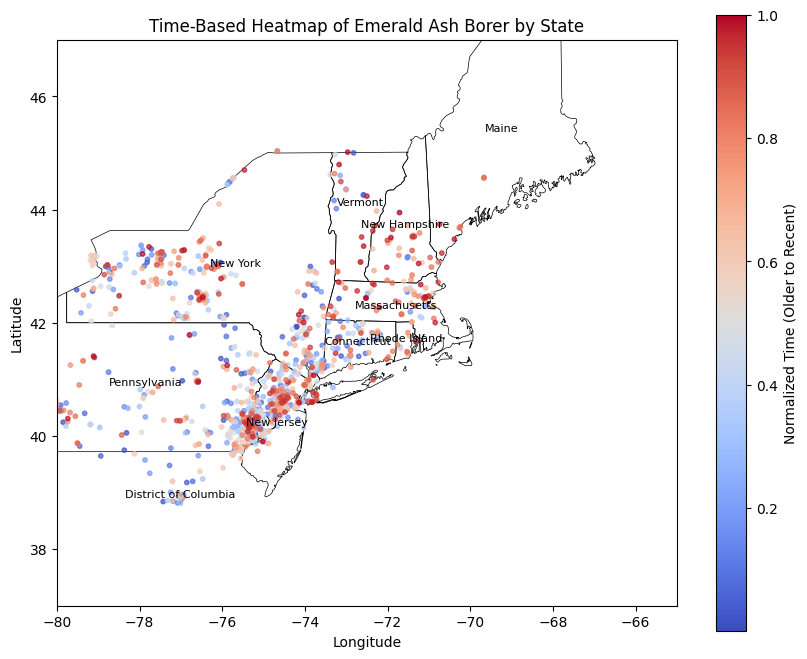

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from scipy.stats import rankdata

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/AI4C/Final_Project/northeast_invasive_insects.csv')

# Filter for Species
data = data[data['taxon_species_name'] == SPECIES_NAME]
data = data.dropna(subset=['time_observed_at'])

# Convert timestamps to datetime
data['time_observed_at'] = pd.to_datetime(data['time_observed_at'])

# Normalize timestamps for color mapping
data['time_seconds'] = (data['time_observed_at'] - data['time_observed_at'].min()).dt.total_seconds()
data['time_percentile'] = rankdata(data['time_seconds'], method='max') / len(data)

# Load states shapefile
shapefile_path = "/content/drive/MyDrive/AI4C/Final_Project/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp"
states = gpd.read_file(shapefile_path)

northeast_states = ['New York', 'Vermont', 'New Hampshire', 'Maine','Massachusetts', 'Connecticut', 'Rhode Island', 'New Jersey', 'Pennsylvania', 'District of Columbia', ]

states = states[states['name'].isin(northeast_states)]

# Convert data to GeoDataFrame
data_gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['longitude'], data['latitude']),
    crs="EPSG:4326"
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot states
states.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5, zorder=1)

# Plot sightings
sc = data_gdf.plot(
    ax=ax,
    column='time_percentile',
    cmap='coolwarm',
    alpha=0.7,
    markersize=10,
    legend=True,
    legend_kwds={'label': "Normalized Time (Older to Recent)"}
)

# Add titles and labels
for x, y, label in zip(states.geometry.centroid.x, states.geometry.centroid.y, states['name']):
  if -80 < x < -65.0 and 37.0 < y < 47.0:
    ax.text(x, y, label, fontsize=8, ha='center', zorder=3)
plt.xlim(-80.0, -65.0)  # Longitude range
plt.ylim(37.0, 47.0)    # Latitude range
plt.title(f"Time-Based Heatmap of {COMMON_NAME} by State")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.stats import rankdata
from sklearn.metrics import r2_score
from geopy.distance import geodesic
from shapely.geometry import Point

# List of counties in the northeastern U.S.
northeast_counties = [
    "Fairfield", "Hartford", "Litchfield", "Middlesex", "New Haven", "New London", "Tolland", "Windham", # Connecticut
    "Androscoggin", "Aroostook", "Cumberland", "Franklin", "Hancock", "Kennebec", "Knox", "Lincoln",
    "Oxford", "Penobscot", "Piscataquis", "Sagadahoc", "Somerset", "Waldo", "Washington", "York", # Maine
    "Barnstable", "Berkshire", "Bristol", "Dukes", "Essex", "Franklin", "Hampden", "Hampshire", "Middlesex",
    "Nantucket", "Norfolk", "Plymouth", "Suffolk", "Worcester", # Massachusetts
    "Belknap", "Carroll", "Cheshire", "Coös", "Grafton", "Hillsborough", "Merrimack", "Rockingham",
    "Strafford", "Sullivan", # New Hampshire
    "Atlantic", "Bergen", "Burlington", "Camden", "Cape May", "Cumberland", "Essex", "Gloucester",
    "Hudson", "Hunterdon", "Mercer", "Middlesex", "Monmouth", "Morris", "Ocean", "Passaic", "Salem",
    "Somerset", "Sussex", "Union", "Warren", # New Jersey
    "Albany", "Allegany", "Bronx", "Broome", "Cattaraugus", "Cayuga", "Chautauqua", "Chemung", "Chenango",
    "Clinton", "Columbia", "Cortland", "Delaware", "Dutchess", "Erie", "Essex", "Franklin", "Fulton",
    "Genesee", "Greene", "Hamilton", "Herkimer", "Jefferson", "Kings", "Lewis", "Livingston", "Madison",
    "Monroe", "Montgomery", "Nassau", "New York", "Niagara", "Oneida", "Onondaga", "Ontario", "Orange",
    "Orleans", "Oswego", "Otsego", "Putnam", "Queens", "Rensselaer", "Richmond", "Rockland", "Saratoga",
    "Schenectady", "Schoharie", "Schuyler", "Seneca", "St. Lawrence", "Steuben", "Suffolk", "Sullivan",
    "Tioga", "Tompkins", "Ulster", "Warren", "Washington", "Wayne", "Westchester", "Wyoming", "Yates", # New York
    "Adams", "Allegheny", "Armstrong", "Beaver", "Bedford", "Berks", "Blair", "Bradford", "Bucks", "Butler",
    "Cambria", "Cameron", "Carbon", "Centre", "Chester", "Clarion", "Clearfield", "Clinton", "Columbia",
    "Crawford", "Cumberland", "Dauphin", "Delaware", "Elk", "Erie", "Fayette", "Forest", "Franklin",
    "Fulton", "Greene", "Huntingdon", "Indiana", "Jefferson", "Juniata", "Lackawanna", "Lancaster",
    "Lawrence", "Lebanon", "Lehigh", "Luzerne", "Lycoming", "McKean", "Monroe", "Montgomery", "Montour",
    "Northampton", "Northumberland", "Perry", "Philadelphia", "Pike", "Potter", "Schuylkill", "Snyder",
    "Somerset", "Sullivan", "Susquehanna", "Tioga", "Union", "Venango", "Warren", "Washington", "Wayne",
    "Westmoreland", "Wyoming", "York", # Pennsylvania
    "Bristol", "Kent", "Newport", "Providence", "Washington", # Rhode Island
    "Addison", "Bennington", "Caledonia", "Chittenden", "Essex", "Franklin", "Grand Isle", "Lamoille",
    "Orange", "Orleans", "Rutland", "Washington", "Windham", "Windsor" # Vermont
]

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/AI4C/Final_Project/northeast_invasive_insects.csv')

data = data.sort_values(by='time_observed_at')

data = data[data['taxon_species_name'] == SPECIES_NAME]

# Convert time_observed_at to datetime and filter out rows without timestamps
data['time_observed_at'] = pd.to_datetime(data['time_observed_at'], errors='coerce')
data = data.dropna(subset=['time_observed_at']).reset_index(drop=True)

# Extract year, month, and day from time_observed_at
data['year'] = data['time_observed_at'].dt.year
data['month'] = data['time_observed_at'].dt.month
data['day'] = data['time_observed_at'].dt.day

# Define features and target
features = ['latitude', 'longitude', 'year', 'month', 'day']
X = data[features].values
y = data[['latitude', 'longitude']].values  # Predict future latitude and longitude

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Create sequences for LSTM
sequence_length = 12  # Use 12 time steps for each sequence
X_seq, y_seq = [], []
for i in range(len(X) - sequence_length):
    X_seq.append(X[i:i + sequence_length])
    y_seq.append(y[i + sequence_length])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

n = len(X_seq)
train_end = int(n * train_ratio)
val_end = int(n * (train_ratio + val_ratio))

# Train-Validation-Test split
X_train, y_train = X_seq[:train_end], y_seq[:train_end]
X_val, y_val = X_seq[train_end:val_end], y_seq[train_end:val_end]
X_test, y_test = X_seq[val_end:], y_seq[val_end:]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Reshape, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Reshape X_train, X_val, and X_test to 2D for scaling
X_train_reshape = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_val_reshape = X_val.reshape((X_val.shape[0], X_val.shape[1] * X_val.shape[2]))
X_test_reshape = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

# Scale y (Outputs)
scaler_y = StandardScaler() # Create a new scaler for the output (y)
y_train_scaled = scaler_y.fit_transform(y_train) # Fit and transform y_train
y_val_scaled = scaler_y.transform(y_val) # Transform y_val
y_test_scaled = scaler_y.transform(y_test) # Transform y_test

# Reverse scaling during prediction
def reverse_scaling(predictions, scaler):
    # Apply inverse transform directly to predictions (no reshape needed)
    original_scale_data = scaler.inverse_transform(predictions)
    return original_scale_data

# Refined LSTM-CNN hybrid model
model = Sequential([
    Input(shape=(12, X_train.shape[2])),  # Input shape matches X_seq
    Reshape((12, X_train.shape[2], 1)),
    TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(1e-4))),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    TimeDistributed(Dense(256, activation='relu')),
    BatchNormalization(),
    LSTM(64, activation='relu', return_sequences=False, kernel_regularizer=l2(1e-4)),
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.4),
    Dense(2, kernel_regularizer=l2(1e-4))  # Latitude and Longitude output
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

# Print model summary
model.summary()

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train,
    y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val_scaled),
    callbacks=[checkpoint, early_stopping]
)

# Load the best weights
model.load_weights('best_model.keras')

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test_scaled, verbose=1)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict and reverse-scale
predictions = model.predict(X_test)
predictions_original_scale = reverse_scaling(predictions, scaler_y)
y_test_original_scale = scaler_y.inverse_transform(y_test_scaled)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 12, 5, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 12, 3, 128)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 12, 3, 128)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 12, 1, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 12, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 12, 256)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 12, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,394 (466.38 KB)

 Trainable params: 118,626 (463.38 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 2.6914 - mae: 1.2116
Epoch 1: val_loss improved from inf to 1.40426, saving model to best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 397ms/step - loss: 2.6818 - mae: 1.2104 - val_loss: 1.4043 - val_mae: 0.9486
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0954 - mae: 1.1089
Epoch 2: val_loss improved from 1.40426 to 1.39826, saving model to best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0939 - mae: 1.1084 - val_loss: 1.3983 - val_mae: 0.9460
Epoch 3/100
13/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0282 - mae: 1.0945 
Epoch 3: val_loss did not improve from 1.39826
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0058 - mae: 1.0894 - val_loss: 1.4134 - val_mae: 0.9504
Epoch 4/100
13/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0781 - mae: 1.1048 
Epoch 4: val_loss did not improve from 1.39826
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0034 - mae: 1.0848 - val_loss: 1.4176 - val_mae: 

Percentile Spread Comparison (Latitude):
90th Percentile - Predicted: 41.35, Actual: 43.40
95th Percentile - Predicted: 41.36, Actual: 43.70
99th Percentile - Predicted: 41.37, Actual: 44.90

Percentile Spread Comparison (Longitude):
90th Percentile - Predicted: -75.18, Actual: -71.30
95th Percentile - Predicted: -75.11, Actual: -70.99
99th Percentile - Predicted: -75.06, Actual: -69.95
Geographic Error (km): 87.51190452910988


<ipython-input-6-1d0f4a88123a>:131: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(counties.geometry.centroid.x, counties.geometry.centroid.y, counties['NAME']):


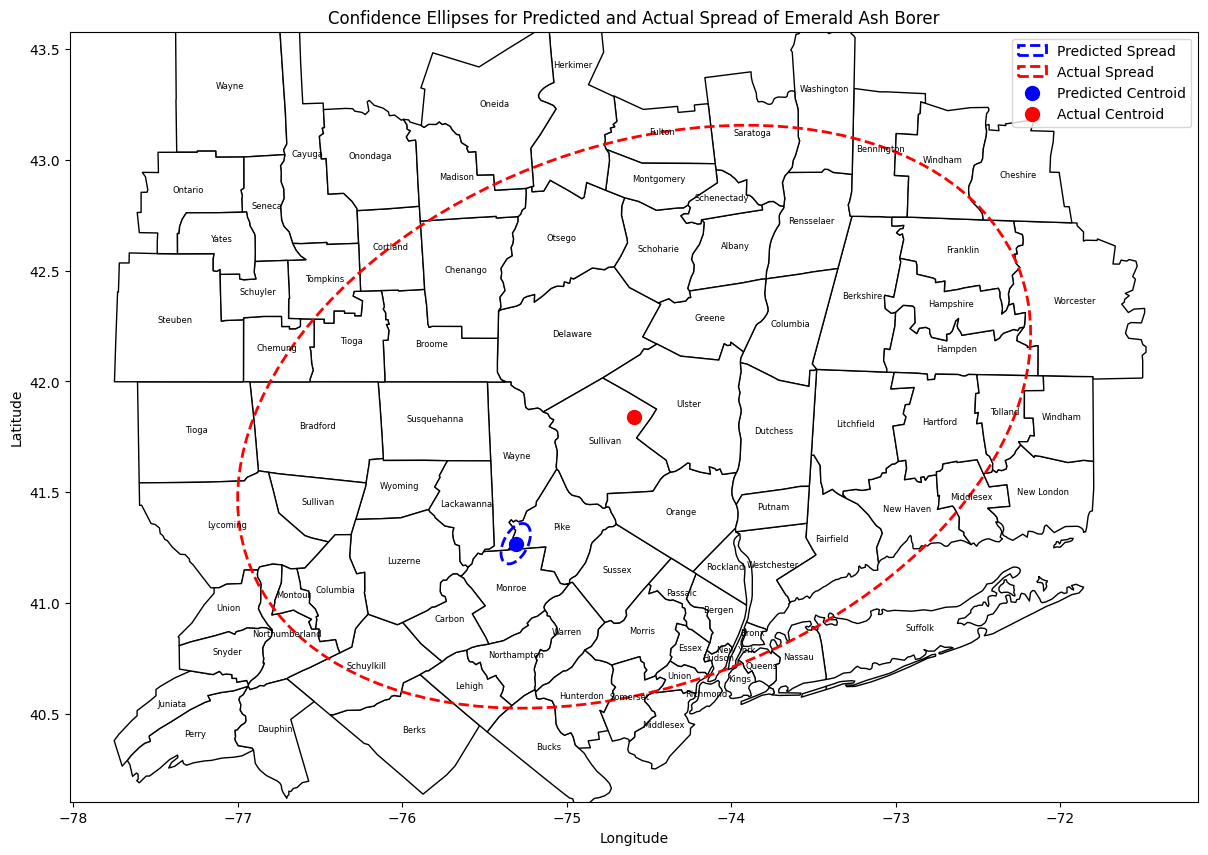

In [ ]:
percentiles = [90, 95, 99]

def percentile_spread_comparison(predictions, actual, percentiles=[10, 50, 90]):
    """
    Compare percentile spreads for predictions and actual data.
    """
    pred_lat_percentiles = np.percentile(predictions[:, 0], percentiles)
    pred_lon_percentiles = np.percentile(predictions[:, 1], percentiles)
    actual_lat_percentiles = np.percentile(actual[:, 0], percentiles)
    actual_lon_percentiles = np.percentile(actual[:, 1], percentiles)

    return {
        'Latitude': {
            'Predicted': pred_lat_percentiles,
            'Actual': actual_lat_percentiles
        },
        'Longitude': {
            'Predicted': pred_lon_percentiles,
            'Actual': actual_lon_percentiles
        }
    }

# Compute percentile spread comparison
spread_comparison = percentile_spread_comparison(predictions_original_scale, y_test_original_scale, percentiles)

# Print the results
print("Percentile Spread Comparison (Latitude):")
for p, pred, actual in zip(percentiles, spread_comparison['Latitude']['Predicted'], spread_comparison['Latitude']['Actual']):
    print(f"{p}th Percentile - Predicted: {pred:.2f}, Actual: {actual:.2f}")

print("\nPercentile Spread Comparison (Longitude):")
for p, pred, actual in zip(percentiles, spread_comparison['Longitude']['Predicted'], spread_comparison['Longitude']['Actual']):
    print(f"{p}th Percentile - Predicted: {pred:.2f}, Actual: {actual:.2f}")


# Calculate the predicted centroid
predicted_centroid = predictions_original_scale.mean(axis=0)

# Calculate actual centroid
actual_centroid = y_test_original_scale.mean(axis=0)

# Calculate the geographic error
geo_error = geodesic(actual_centroid, predicted_centroid).km

# Print the results
print("Geographic Error (km):", geo_error)

from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Plot the predicted and actual spreads on the map
fig, ax = plt.subplots(figsize=(16, 10))

# Function to create confidence ellipse
def create_confidence_ellipse(data, ax, color, label, zorder=3):
    # Calculate covariance matrix and mean
    cov = np.cov(data[:, 1], data[:, 0])  # Covariance of longitude, latitude
    mean_lon, mean_lat = np.mean(data[:, 1]), np.mean(data[:, 0])

    # Eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eig(cov)
    width = max(0.001, 2 * np.sqrt(eigvals[0]) ) # Scale by 2 standard deviations
    height = max(0.001, 2 * np.sqrt(eigvals[1]))
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    # Create and add ellipse
    ellipse = Ellipse(
        xy=(mean_lon, mean_lat),
        width=width,
        height=height,
        angle=angle,
        edgecolor=color,
        facecolor='none',
        linestyle='--',
        linewidth=2,
        label=label
    )
    ax.add_patch(ellipse)
    return mean_lon, mean_lat, width, height  # Return center for reference

# Add confidence ellipses
pred_mean_lon, pred_mean_lat, pred_width, pred_height = create_confidence_ellipse(
    predictions_original_scale, ax, color='blue', label='Predicted Spread'
)
actual_mean_lon, actual_mean_lat, actual_width, actual_height = create_confidence_ellipse(
    y_test_original_scale, ax, color='red', label='Actual Spread'
)

# Add points for centroids
predicted_point = gpd.GeoDataFrame(
    geometry=[Point(predicted_centroid[1], predicted_centroid[0])],  # Longitude, Latitude
    crs="EPSG:4326"
)
actual_point = gpd.GeoDataFrame(
    geometry=[Point(actual_centroid[1], actual_centroid[0])],  # Longitude, Latitude
    crs="EPSG:4326"
)
predicted_point.plot(ax=ax, color='blue', markersize=100, label='Predicted Centroid', zorder=4)
actual_point.plot(ax=ax, color='red', markersize=100, label='Actual Centroid', zorder=4)

# Calculate the bounding box using the larger of the two spreads
min_lon = min(pred_mean_lon - pred_width / 2, actual_mean_lon - actual_width / 2)
max_lon = max(pred_mean_lon + pred_width / 2, actual_mean_lon + actual_width / 2)
min_lat = min(pred_mean_lat - pred_height / 2, actual_mean_lat - actual_height / 2)
max_lat = max(pred_mean_lat + pred_height / 2, actual_mean_lat + actual_height / 2)

# Optional: Add padding
padding_lat = (max_lat - min_lat) * 0.2
padding_lon = (max_lon - min_lon) * 0.2

# Define the shapefile path
shapefile_path = "/content/drive/MyDrive/AI4C/Final_Project/ne_10m_admin_2_counties/ne_10m_admin_2_counties.shp"

# Load counties shapefile
counties = gpd.read_file(shapefile_path)

# Filter for northeastern counties
counties = counties[counties['NAME'].isin(northeast_counties)]

# Ensure counties CRS matches centroids
if counties.crs != "EPSG:4326":
    counties = counties.to_crs("EPSG:4326")

# Filter counties to the northeastern U.S.
counties = counties.cx[min_lon:max_lon, min_lat:max_lat]

# Add county names (optional)
for x, y, label in zip(counties.geometry.centroid.x, counties.geometry.centroid.y, counties['NAME']):
    ax.text(x, y, label, fontsize=6, ha='center', zorder=5)

counties.plot(ax=ax, color='white', edgecolor='black', zorder=0)

# Set plot limits to focus on the northeastern U.S.
plt.xlim(min_lon - padding_lon, max_lon + padding_lon)
plt.ylim(min_lat - padding_lat, max_lat + padding_lat)

# Customize plot
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Confidence Ellipses for Predicted and Actual Spread of {COMMON_NAME}")
plt.legend()
plt.grid(False)  # Remove gridlines for better clarity
plt.show()